<a href="https://colab.research.google.com/github/malvibid/COMP3029-Computer-Vision/blob/main/COMP3029_Computer_Vision_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP3029 COMPUTER VISION COURSEWORK** 

*Spring 2022/2023*, School of Computer Science, University of Nottingham Malaysia

```
GROUP 4: 
  20306551 - Mustafa Mehmood
  20311657 - Omar Ismail
  20311860 - Gabriel Hoh Chao Jei
  20187945 - Malvi Bid
```





# ⚡Challenges

```
Key: ✅ Challenge solved 🟥 Pending solution
```

*   ✅ 6 images in Batch-3 were not being segmented correctly. I double-checked the bounding box coordinates and drew them on the image, they were positioned correctly. After further inspection I realised the issue was with the PIL image library we were using. Therefore, I switched to using OpenCV, this resolved the issue. 

# Import Dependencies

In [ ]:
# WandB for monitoring performance
!pip install wandb -q
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 1.3 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from google.colab import drive
from google.colab.patches import cv2_imshow


# Mount google drive

In [ ]:
# Mount drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Setting path to the datasets root folder
dataset_root_dir = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

# Dataset folder structure

In [ ]:
!ls -F '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

Batch-1/  Batch-2/  Batch-3/


In [ ]:
print("Batch-1/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1'
print("\nBatch-2/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2'
print("\nBatch-3/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3'

Batch-1/ 
seedsegment@  seedsplit@

Batch-2/ 
NormalRoomLighting@  seedsegment/  NormalRoomLight_annotation.csv

Batch-3/ 
LightBox@  seedsegment/  LightBox_annotation.csv


## Dataset structure tree

### Original folders tree


```
.
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       │
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    │
    ├── Batch-2/
    │   ├── NormalRoomLight_annotation.csv
    │   └── NormalRoomLighting/
    │       ├── Set1/
    │       ├── ...
    │       └── Set15/
    │
    └── Batch-3/
        ├── LightBox_annotation.csv
        └── LightBox/
            ├── Set1/
            ├── ...
            └── Set20/
```

### Folders tree after extracting Batch-2 and Batch-3 images



```
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    ├── Batch-2/
    │   ├── seedcropped/
    │   │   └── test/
    │   │       ├── BadSeed/
    │   │       └── GoodSeed/
    │   └── seedsegment/
    │       └── test/
    │           ├── BadSeed/
    │           └── GoodSeed/
    └── Batch-3/
        ├── seedcropped/
        │   └── test/
        │       ├── BadSeed/
        │       └── GoodSeed/
        └── seedsegment/
            └── test/
                ├── BadSeed/
                └── GoodSeed/
  ```

# Extracting Batch-2 and Batch-3 individual seed images

The individual seed images have been extracted in folders as per the [folder structure](#scrollTo=N7skd4hymIFJ&line=46&uniqifier=1) defined in the dataset folder structure section above.

For sake of comparison, we extracted two versions of individual seed images for both Batch-2 and Batch-3. In the first version, the images are only cropped as per the given bounding box coordinates. The resulting cropped images have been extracted in a folder named `seedcropped`. Whereas in the second version, similar to the images in Batch-1, the images have been cropped and resized to 256px by 256px. These images have been extracted in a folder named `seedsegment`. 

In [ ]:
def extract_seed_image(annotations_csv, resize=True):
  print("Extracting images...")
  # Read the CSV file
  seed_df = pd.read_csv(annotations_csv)

  for index, row in seed_df.iterrows():
    # Get all image variables
    img_path = row["file_name"].rsplit('.')[0] + '.JPG'
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    class_label = 'GoodSeed' if row["bbox_label"] == 'GOOD' else 'BadSeed' if row["bbox_label"] == 'BAD' else 'Labelling error' # Ensuring each sample in the csv is labelled correctly.
    
    # Read the image file
    image = cv2.imread(img_path)

    # Crop the image using the given bounds
    cropped_image = image[y_min:y_max, x_min:x_max].copy()

    if resize:
      # Resize the cropped image to 256x256
      resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)
      folder_name = 'seedsegment'
    else:
      folder_name = 'seedcropped'

    # Specify path to save the extracted image. Batch-<num>/<folder_name>/test/<class-cabel>
    data_dir = os.path.join(os.path.dirname(annotations_csv) , f'{folder_name}/test/{class_label}')

    # Create new folders if they don't exist on the path
    if not os.path.exists(data_dir):
      os.makedirs(data_dir)

    # Formatting the image name to <label>test<index>.jpg E.g., goodtest0.jpg, badtest12.jpg
    image_name = f'{row["bbox_label"].lower()}test{index}.jpg' 
    
    if resize:
      # Save the extracted image to specified folder E.g. Batch-2/seedsegment/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', resized_image)
    else:
      # Save the extracted image to specified folder E.g. Batch-2/seedcropped/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', cropped_image)

  print(f'Extracted images saved at: {os.path.dirname(data_dir)}/')
  print("✅ Individual seed image extraction completed.")


In [ ]:
# Setting paths to the annotation files
batch2_annotations_dir = os.path.join(dataset_root_dir, 'Batch-2/NormalRoomLight_annotation.csv')
batch3_annotations_dir = os.path.join(dataset_root_dir, 'Batch-3/LightBox_annotation.csv')

In [ ]:
# Extract Batch-2 images - only cropped
extract_seed_image(batch2_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-2 images - cropped and resized to 256x256
extract_seed_image(batch2_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images - only cropped
extract_seed_image(batch3_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images  - cropped and resized to 256x256
extract_seed_image(batch3_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/
✅ Individual seed image extraction completed.


## Comparing `seedcropped` and `seedsegment` images for Batch-2 and Batch-3

Here is a comparison of the images just cropped vs images cropped and resized. 

Batch 2, sample: 'badtest11.jpg'


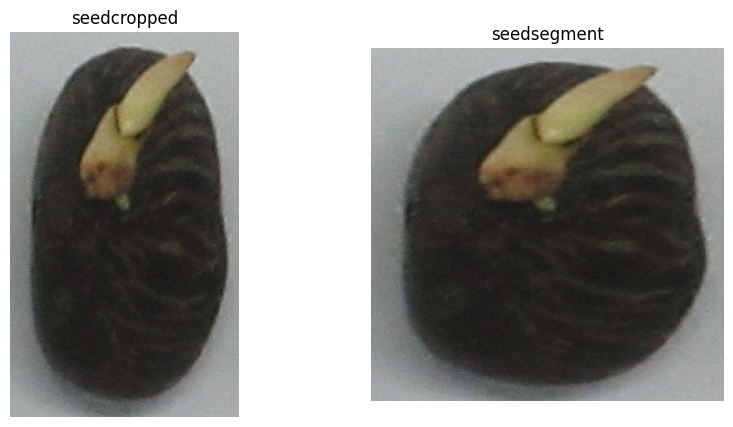



Batch 3, sample: 'badtest13.jpg'


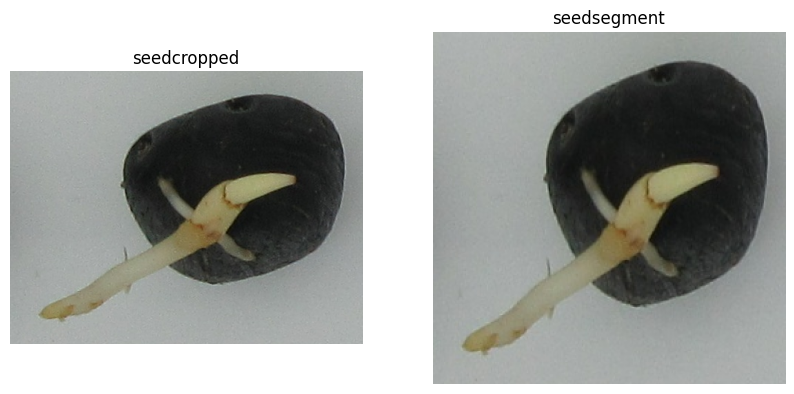

In [ ]:
def display_side_by_side(imgpath1, imgpath2):
  # Load images
  img1 = cv2.imread(imgpath1)
  img2 = cv2.imread(imgpath2)

  # Convert images from BGR to RGB (OpenCV reads images in BGR format)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Plot images side by side
  axs[0].imshow(img1)
  axs[0].axis('off')
  axs[0].set_title('seedcropped')

  axs[1].imshow(img2)
  axs[1].axis('off')
  axs[1].set_title('seedsegment')

  # Display the plot
  plt.show()


print("Batch 2, sample: 'badtest11.jpg'")
b2imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/BadSeed/badtest11.jpg'
b2imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest11.jpg'

display_side_by_side(b2imgpath1, b2imgpath2)

print("\n\nBatch 3, sample: 'badtest13.jpg'")
b3imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/BadSeed/badtest13.jpg'
b3imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSeed/badtest13.jpg'

display_side_by_side(b3imgpath1, b3imgpath2)


# Custom Seed Dataset and Dataloader


In [ ]:
# Custom dataset class inheriting from the PyTorch Dataset class
class SeedDataset(Dataset):
    def __init__(self, dataset_dir=None, train=True, transform=None):
        self.dataset_dir = dataset_dir
        self.train = train
        self.transform = transform
        self.categories = ['BadSeed', 'GoodSeed']
                
        self.data = []
        
        data_dir = os.path.join(self.dataset_dir, 'train' if self.train else 'test')
        for category_idx, category in enumerate(self.categories):
          category_dir = os.path.join(data_dir, category)
          for img_name in os.listdir(category_dir):
              if img_name.endswith('.png') or img_name.endswith('.jpg'):
                  self.data.append((img_name, os.path.join(category_dir, img_name), category_idx))
        
        #print(self.data)
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
      
      img_name, img_path, label = self.data[idx]

      # Read the image file in BGR format
      image_bgr = cv2.imread(img_path)
      
      # Convert the image from BGR to RGB format
      seed_img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

      
      if self.transform:
          seed_img = self.transform(seed_img)

      return img_name, seed_img, label

**Note:** The base dataset directory was defined [above](#scrollTo=YT7yJbFiOYpn&line=1&uniqifier=1) when mounting the google drive. 
You may change the base path there or replace `os.path.join(dataset_root_dir, 'Batch-<num>/seedsegment')` below to an absolute path to the cropped (seedsegment) images in your drive for each batch.

In [ ]:
# Defining paths to dataset directories
batch1_dataset_dir = os.path.join(dataset_root_dir, 'Batch-1/seedsegment')
batch2_dataset_dir = os.path.join(dataset_root_dir, 'Batch-2/seedsegment')
batch3_dataset_dir = os.path.join(dataset_root_dir, 'Batch-3/seedsegment')

In [ ]:
# Define the image transformations
image_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# Define batch size
BATCH_SIZE = 32

In [ ]:
# Instantiate the custom SeedDataset and dataloader

# Get Training dataset from Batch-1
train_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=True, transform=image_transforms)

# Split Training dataset into Training and Validation sets with a roughly 80/20 split
train_b1_dataset, validate_b1_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])

# Load Training and Validation datesets.
train_b1_dataloader = DataLoader(dataset=train_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validate_b1_dataloader = DataLoader(dataset=validate_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Get and load Testing dataset from Batch-1,2,3
test_b1_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=False, transform=image_transforms)
test_b1_dataloader = DataLoader(dataset=test_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b2_dataset = SeedDataset(dataset_dir=batch2_dataset_dir, train=False, transform=image_transforms)
test_b2_dataloader = DataLoader(dataset=test_b2_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b3_dataset = SeedDataset(dataset_dir=batch3_dataset_dir, train=False, transform=image_transforms)
test_b3_dataloader = DataLoader(dataset=test_b3_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


## Testing dataset and dataloader

In [ ]:
# Checking the dataset length and a sample of data
print(f"B1 Train Dataset length: {len(train_b1_dataset)}")
print(f"B1 Train Data sample: {train_dataset.data[train_b1_dataset.indices[0]]}\n") # Access the first training sample from the original train_dataset using the index of first training sub-sample

print(f"B1 Validation Dataset length: {len(validate_b1_dataset)}")
print(f"B1 Validation Data sample: {train_dataset.data[validate_b1_dataset.indices[0]]}\n") # Access the first validation sample from the original train_dataset using the index of first validation sub-sample

print(f"B1 Test Dataset length: {len(test_b1_dataset.data)}")
print(f"B1 Test Data sample: {test_b1_dataset.data[0]}\n")

print(f"B2 Test Dataset length: {len(test_b2_dataset.data)}")
print(f"B2 Test Data sample: {test_b2_dataset.data[0]}\n")

print(f"B3 Test Dataset length: {len(test_b3_dataset.data)}")
print(f"B3 Test Data sample: {test_b3_dataset.data[0]}\n")

B1 Train Dataset length: 1401
B1 Train Data sample: ('goodtrain4.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/GoodSeed/goodtrain4.png', 1)

B1 Validation Dataset length: 351
B1 Validation Data sample: ('goodtrain899.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/GoodSeed/goodtrain899.png', 1)

B1 Test Dataset length: 401
B1 Test Data sample: ('badtest2.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/test/BadSeed/badtest2.png', 0)

B2 Test Dataset length: 900
B2 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest10.jpg', 0)

B3 Test Dataset length: 1198
B3 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSeed

In [ ]:
# Get a batch of data from the data loader
b1_train_img_names, b1_train_images, b1_train_labels = next(iter(train_b1_dataloader))
b1_validate_img_names, b1_validate_images, b1_validate_labels = next(iter(validate_b1_dataloader))
b1_test_img_names, b1_test_images, b1_test_labels = next(iter(test_b1_dataloader))
b2_test_img_names, b2_test_images, b2_test_labels = next(iter(test_b2_dataloader))
b3_test_img_names, b3_test_images, b3_test_labels = next(iter(test_b3_dataloader))

### Visualise batches

B1 Train image batch shape: torch.Size([32, 3, 256, 256])
B1 Train labels batch shape: torch.Size([32])
B1 Train labels: tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1])


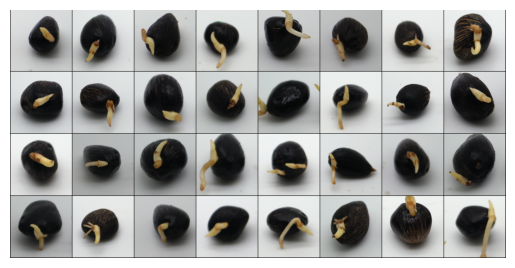

In [ ]:
# Train batch
print(f"B1 Train image batch shape: {b1_train_images.size()}")
print(f"B1 Train labels batch shape: {b1_train_labels.size()}")
print(f"B1 Train labels: {b1_train_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_train_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Validate image batch shape: torch.Size([32, 3, 256, 256])
B1 Validate labels batch shape: torch.Size([32])
B1 Validate labels: tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1])


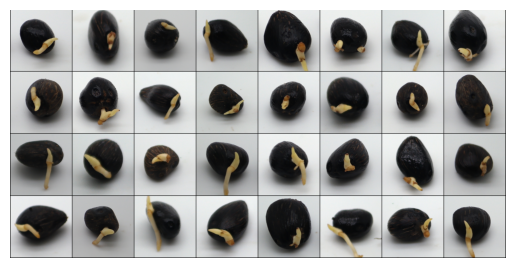

In [ ]:
# Validation batch
print(f"B1 Validate image batch shape: {b1_validate_images.size()}")
print(f"B1 Validate labels batch shape: {b1_validate_labels.size()}")
print(f"B1 Validate labels: {b1_validate_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_validate_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Test image batch shape: torch.Size([32, 3, 256, 256])
B1 Test labels batch shape: torch.Size([32])
B1 Test Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0])


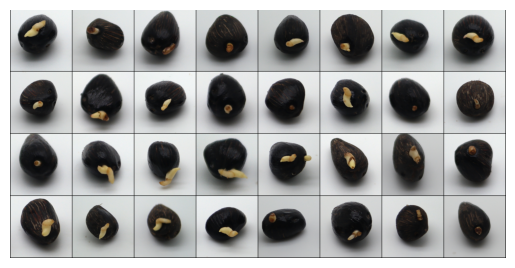

In [ ]:
# Test B1
print(f"B1 Test image batch shape: {b1_test_images.size()}")
print(f"B1 Test labels batch shape: {b1_test_labels.size()}")
print(f"B1 Test Labels: {b1_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B2 Test image batch shape: torch.Size([32, 3, 256, 256])
B2 Test labels batch shape: torch.Size([32])
B2 Test Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1])


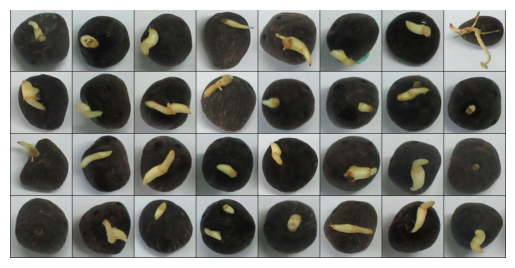

In [ ]:
# Test B2
print(f"B2 Test image batch shape: {b2_test_images.size()}")
print(f"B2 Test labels batch shape: {b2_test_labels.size()}")
print(f"B2 Test Labels: {b2_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b2_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B3 Test image batch shape: torch.Size([32, 3, 256, 256])
B3 Test labels batch shape: torch.Size([32])
B3 Test Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1])


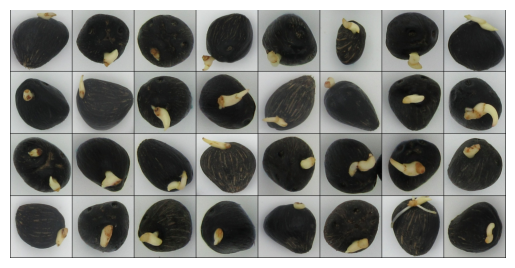

In [ ]:
# Test B3
print(f"B3 Test image batch shape: {b3_test_images.size()}")
print(f"B3 Test labels batch shape: {b3_test_labels.size()}")
print(f"B3 Test Labels: {b3_test_labels}")
# Create a grid of images from the batch to see the individual seed sample
grid = vutils.make_grid(b3_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Transfer Learning with pre-trained ResNet18 model 

* The model is fine-tuned for binary classification (GoodSeed or BadSeed) by replacing the last fully connected layer.

* Cross-entropy loss is used as the loss function because it measures the performance of a classification model whose output is a probability value between 0 and 1, as is the case here. Cross-entropy loss increases as the predicted probability diverges from the actual label.

* The Weights & Biases (wandb) library is used to monitor the model's training progress, and the loss, accuracy, precision, recall, f1-score and AUC for the validation and test sets are logged. 

* This section includes a subsection of experiments which show the different hyperparameters we considered to reach the final version of the model.

In [ ]:
# Initialise wandb
wandb.init(project='seed-classification')

wandb: Currently logged in as: bidmalvi. Use `wandb login --relogin` to force relogin


In [ ]:
# Load the pre-trained ResNet-18 model
resnet18_model = resnet18(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [ ]:
# Modify the resnet18 model for binary classification (GoodSeed or BadSeed)
# Replace the last fully connected layer with a new one for binary classification
num_classes = 2
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)

In [ ]:
# Check if last FC layer has been replaced correctly
print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

## Train and validate

In [ ]:
# Train and validate the model and log data to wandb
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    model = model.to(device)
    wandb.watch(model, log='all')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over the training dataset
        for _, inputs, labels in train_loader:  # (see above) SeedDataset.__getitem__ returns: img_name, seed_img, label 
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Print training statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        wandb.log({"train_loss": epoch_loss, "train_acc": epoch_acc})
        print(f"Epoch {epoch}/{num_epochs-1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Evaluate on the validation dataset
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        y_true = []
        y_pred = []
        y_score = []


        with torch.no_grad():
            for _, inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Store true labels, predicted labels and predicted probabilities
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_score.extend(outputs.cpu().numpy()[:, 1])

            # Compute precision, recall, F1-score, and AUC
            precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
            auc = roc_auc_score(y_true, y_score)

            # Print validation statistics
            epoch_loss = running_loss / len(val_loader.dataset)
            epoch_acc = running_corrects.double() / len(val_loader.dataset)
            wandb.log({"val_loss": epoch_loss, "val_acc": epoch_acc, "precision": precision,"recall": recall, "f1_score": f1_score, "auc": auc})
            print(f"Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1-score: {f1_score:.4f}, AUC: {auc:.4f}")



## Test

In [20]:
# Evaluate the model on the test set
def test_model(model, test_loader, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        for _, inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store true labels, predicted labels and predicted probabilities
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(outputs.cpu().numpy()[:, 1])

        # Compute precision, recall, F1-score, and AUC
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        auc = roc_auc_score(y_true, y_score)

        # Print test statistics
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)
        wandb.log({"test_loss": epoch_loss, "test_acc": epoch_acc, "precision": precision,
                   "recall": recall, "f1_score": f1_score, "auc": auc})
        print(f"Test Loss: {epoch_loss:.4f}, Test Acc: {epoch_acc:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1-score: {f1_score:.4f}, AUC: {auc:.4f}")


## Experiment 1

- Here we have not frozen any layers of the ResNet model, which means that during the backpropagation stage, the optimizer is updating the parameters/weights of the entire ResNet model, including the pre-trained layers. 

  - By not freezing the layers, the model is able to learn task-specific features by updating the weights of the entire network during training. This can lead to better performance. The model can further adapt better to the new dataset, capturing more complex patterns and nuances that may not have been present in the original dataset. Albeit, this comes at a computational cost.

- Stochastic Gradient Descent (SGD) optimizer with momentum is used for optimization with `learning_rate=0.001` and `momentum=0.9`. We selected these values as a starting point as they are default values that have been proven to work well in practice for many deep learning tasks.

- The number of epochs is set to `num_of_epochs=25`, as an arbitrary starting point.


In [ ]:
# Define the optimizer
optimizer_SGD = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_model(resnet18_model, criterion, optimizer_SGD, train_b1_dataloader, validate_b1_dataloader, num_epochs=25)

Epoch 0/24, Loss: 0.1497, Acc: 0.9472
Val Loss: 0.1280, Val Acc: 0.9544, Precision: 0.9752, Recall: 0.9290, F1-score: 0.9515, AUC: 0.9923
Epoch 1/24, Loss: 0.0730, Acc: 0.9814
Val Loss: 0.0919, Val Acc: 0.9658, Precision: 0.9591, Recall: 0.9704, F1-score: 0.9647, AUC: 0.9948
Epoch 2/24, Loss: 0.0415, Acc: 0.9893
Val Loss: 0.0770, Val Acc: 0.9772, Precision: 0.9653, Recall: 0.9882, F1-score: 0.9766, AUC: 0.9959
Epoch 3/24, Loss: 0.0333, Acc: 0.9943
Val Loss: 0.0780, Val Acc: 0.9715, Precision: 0.9760, Recall: 0.9645, F1-score: 0.9702, AUC: 0.9963
Epoch 4/24, Loss: 0.0189, Acc: 0.9979
Val Loss: 0.0818, Val Acc: 0.9744, Precision: 0.9651, Recall: 0.9822, F1-score: 0.9736, AUC: 0.9953
Epoch 5/24, Loss: 0.0134, Acc: 0.9986
Val Loss: 0.0740, Val Acc: 0.9744, Precision: 0.9706, Recall: 0.9763, F1-score: 0.9735, AUC: 0.9966
Epoch 6/24, Loss: 0.0101, Acc: 0.9986
Val Loss: 0.0789, Val Acc: 0.9715, Precision: 0.9595, Recall: 0.9822, F1-score: 0.9708, AUC: 0.9974
Epoch 7/24, Loss: 0.0102, Acc: 0.9

These training results suggest that the model is performing well on both the training and validation datasets. The training accuracy reaches 100%, indicating that the model can correctly classify all training samples. The validation accuracy is also high, ranging from 95.44% to 98.29%, which demonstrates that the model is generalizing well to unseen data.

The precision, recall, and F1-score are consistently high across epochs, indicating that the model is correctly identifying positive (GoodSeed) samples and is not misclassifying many negative samples as positive. The area under the ROC curve (AUC) is also consistently high (above 0.99), which shows that the model is doing a good job in ranking samples based on their probability of belonging to the positive class.

It's worth noting that the training accuracy reaches 100% quite early in the training process, suggesting that the model may have started overfitting the training data. However, the validation metrics (accuracy, precision, recall, F1-score, and AUC) remain stable and high, which means that the model is still generalizing well despite the potential overfitting. It could be useful to monitor these metrics and stop training early if they start to degrade, or use regularization techniques such as dropout or weight decay to mitigate overfitting (see experiment 2).

In [22]:
# Test Batch-1 dataset
test_model(resnet18_model, test_b1_dataloader)

Test Loss: 0.0580, Test Acc: 0.9900, Precision: 0.9900, Recall: 0.9900, F1-score: 0.9900, AUC: 0.9971


In [23]:
# Test Batch-2 dataset
test_model(resnet18_model, test_b2_dataloader)

Test Loss: 0.4759, Test Acc: 0.8289, Precision: 0.8737, Recall: 0.7689, F1-score: 0.8180, AUC: 0.9138


In [24]:
# Test Batch-3 dataset
test_model(resnet18_model, test_b3_dataloader)

Test Loss: 0.6279, Test Acc: 0.8147, Precision: 0.7516, Recall: 0.9455, F1-score: 0.8375, AUC: 0.9117


In summary, the trained model performs exceptionally well on the first test dataset but has reduced performance on the second and third datasets. The differences in performance may be due to the different light conditions of each batch or the model overfitting the training data. Further analysis and experimentation is required to understand and improve the model's performance on the latter two datasets.

In [ ]:
wandb.finish()